# (sqrt) **Ridge** 

---

## 0. Importing dependencies

In [1]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


import warnings
warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [2]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [3]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Venezuela', 'Country_Sri Lanka', 'Country_Croatia', 'Country_Jordan', 'Country_Slovakia', 'Country_Zimbabwe', 'Country_Bangladesh', 'Country_Latvia', 'Country_Viet Nam', 'Country_Azerbaijan', 'Country_Philippines', 'Country_Mongolia', 'Country_North Macedonia', 'Country_Malta', 'Country_Paraguay', 'Country_Yemen', 'Country_Lebanon', 'Country_Costa Rica', 'Country_Kenya', 'Country_Kosovo', 'Country_Cyprus', 'Country_Saudi Arabia', 'Country_Nomadic', 'Country_Angola', 'Country_Uzbekistan', 'Country_Armenia', 'Country_Estonia', 'Country_Serbia', 'Ethnicity_North American / Central American', 'Country_Peru', 'Country_El Salvador', 'Country_Georgia', 'Country_United Arab Emirates', 'Country_Botswana', 'Country_New Zealand', 'Country_Bosnia-Herz.', 'Country_Tanzania', 'Country_Andorra'}
Columns in the test set that aren't in the train set: {'Country_Barbados', 'Country_Qatar', 'Country_Guinea', "Country_CÃ´te d'Ivoire", 'Country

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [4]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

# Upon exploration in MLR results, we found that the following columns are adding noise to the model
# as they correspond to values mainly from USA with non-sense relationship mainly Work_experience - Annual_salary
# Hence, we will remove them from the baseline model
baseline_train_df.drop([2153,359, 281, 297, 432, 601, 309, 239, 409, 454], inplace=True)
baseline_test_df.drop(538, inplace=True)

baseline_train_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Argentina,Country_Australia,Country_Austria,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.6,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,5.8,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.6,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,12.2,62820.0


In [5]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = np.sqrt(baseline_train_df['Annual_salary'])
y_test = np.sqrt(baseline_test_df['Annual_salary'])

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2248, 92)
(2248,)

(552, 92)
(552,)


---

### 2.2. Identifying the target

In [6]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = np.sqrt(train_df['Annual_salary'])
# y_test = np.sqrt(test_df['Annual_salary'])
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importance
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

In [8]:
model = Ridge()

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {'alpha': np.logspace(-4, 4, num=100)
}

def custom_rmse(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    mse = mean_squared_error(y_true_original, y_pred_original)
    return np.sqrt(mse)

def custom_r2(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    return r2_score(y_true_original, y_pred_original)

custom_scorer = {'r2': make_scorer(custom_r2, greater_is_better=True),  
                 'rmse': make_scorer(custom_rmse, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=custom_scorer, return_train_score=True,
                   n_jobs=-1, random_state=42, verbose=2)  
clf.fit(X_train_scaled, y_train)


best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


Best parameters found: {'alpha': 1.9179102616724888}


#### 3.1.1. CV results

Let's look at results per parameter combination

In [9]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.581062,0.558705,32543.925637,33354.734308
1,0.625586,0.596598,30765.917109,31879.479865
2,0.623007,0.595187,30871.699037,31936.991851
3,0.625602,0.596557,30765.271164,31880.992183
4,0.625602,0.596555,30765.250122,31881.079654
5,0.625604,0.596548,30765.194097,31881.345934
6,0.625604,0.596543,30765.163953,31881.517579
7,0.601636,0.577441,31734.645636,32635.607884
8,0.625604,0.596543,30765.162841,31881.524434
9,0.625604,0.596543,30765.162729,31881.525129


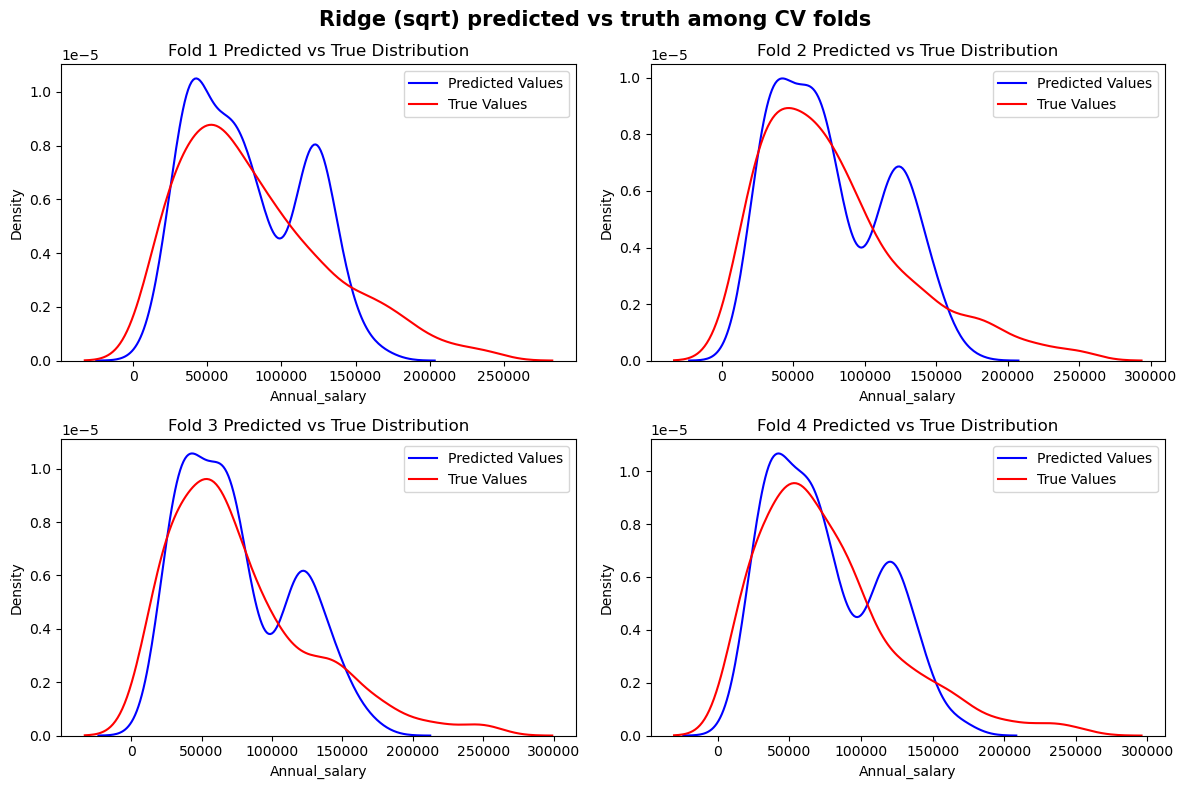

In [10]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    y_fold_pred = clf.predict(X_fold_test)

    plt.subplot(2, 2, fold_num)
    sns.kdeplot(np.power(y_fold_pred,2), color='blue', label='Predicted Values')
    sns.kdeplot(np.power(y_fold_true,2), color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1

plt.suptitle('Ridge (sqrt) predicted vs truth among CV folds', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

Now, the average of folds:

In [11]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  
mean_train_r2 = np.mean(df_cv_results['mean_train_r2']) 
mean_train_rmse = np.mean(df_cv_results['mean_train_rmse'])
 
print(f"Mean CV Train R2: {mean_train_r2}")
print(f"Mean CV Train RMSE: {mean_train_rmse}")
print('-'*20)
print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Train R2: 0.6184912761261054
Mean CV Train RMSE: 31050.73923255342
--------------------
Mean CV Test R2: 0.5907220829178753
Mean CV Test RMSE: 32109.479882009007


### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [12]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y_true, inverse_transform=True):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    if inverse_transform:
        y_pred = np.power(y_pred, 2)  
        y_true = np.power(y_true, 2) 
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train set results


Train set metrics:
R^2: 0.6221066058233271
RMSE: 30915.80627237569
Adjusted R^2: 0.6059738019884064


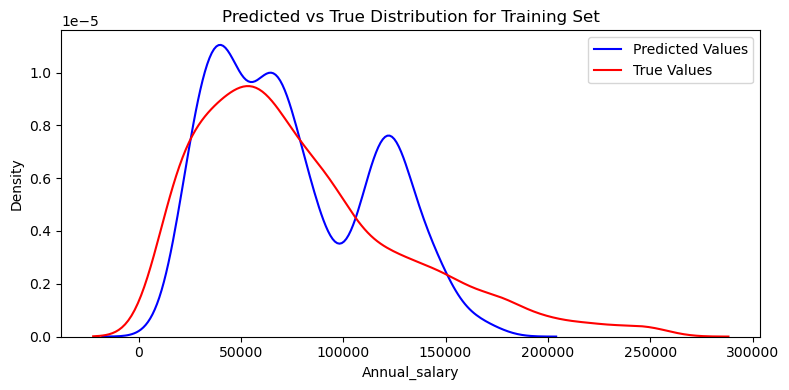

In [13]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")

y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(np.power(y_train_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_train,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: 0.6418273229383293
RMSE: 29645.859536027107
Adjusted R^2: 0.5700367210000424


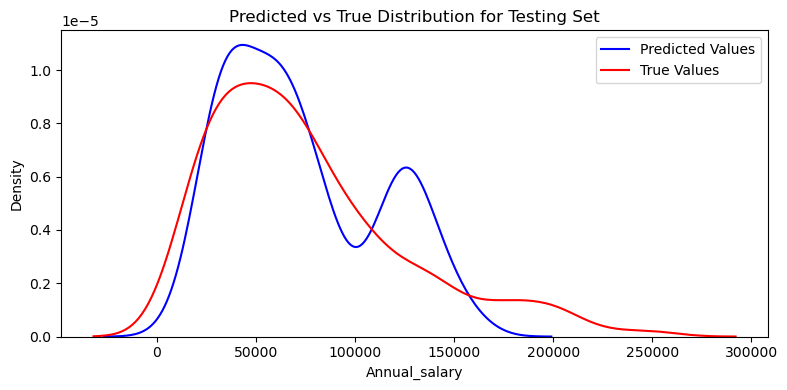

In [14]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")
    
y_test_pred = clf.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(np.power(y_test_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_test,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

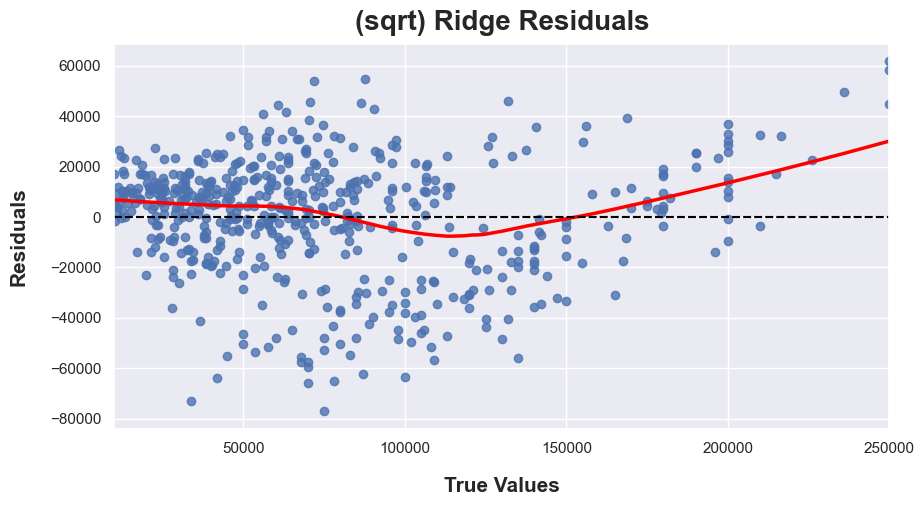

In [16]:
sns.set_theme(style='darkgrid')

residuals = np.power(y_test, 2) - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=np.power(y_test, 2), y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('(sqrt) Ridge Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/sqrt-ridge-test-residuals.pdf");

### 4.2. Test set performance

<Figure size 1000x600 with 0 Axes>

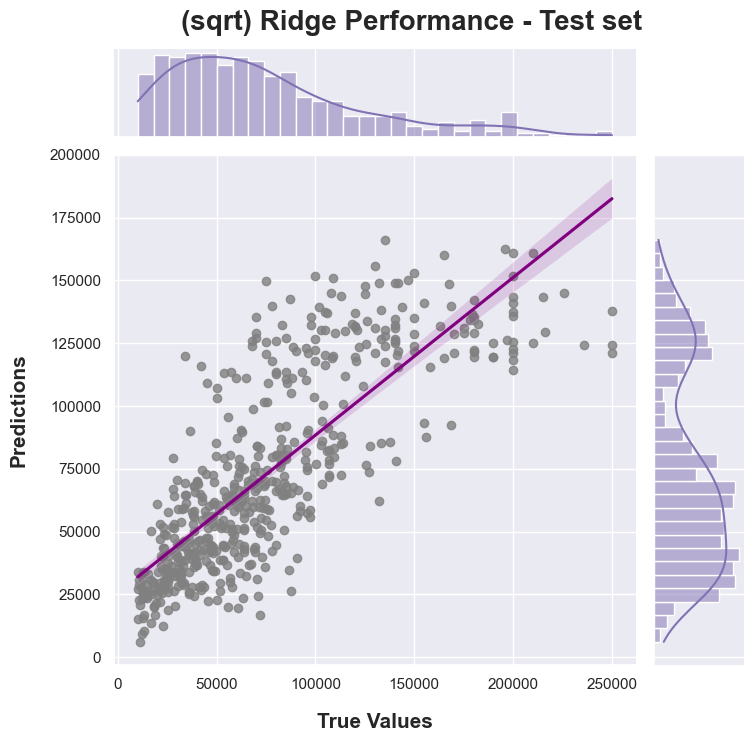

In [17]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=np.power(y_test, 2), y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('(sqrt) Ridge Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-ridge-test-predictions.pdf");

## 6. Saving results

Saving CV results

In [18]:
df_cv_results.to_csv("../../output/sqrt-ridge-cv-results.csv")

Saving train and test sets predictions

In [19]:
np.savetxt("../../output/sqrt-ridge-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/sqrt-ridge-test-predictions.csv", y_pred_test, delimiter=",")

In [20]:
pd.set_option('display.max_colwidth', None)

df_cv_results[['params', 'mean_train_r2', 'mean_test_r2']]

,params,mean_train_r2,mean_test_r2
0,{'alpha': 509.4138014816386},0.581062,0.558705
1,{'alpha': 1.9179102616724888},0.625586,0.596598
2,{'alpha': 45.34878508128591},0.623007,0.595187
3,{'alpha': 0.43287612810830617},0.625602,0.596557
4,{'alpha': 0.3593813663804629},0.625602,0.596555
5,{'alpha': 0.14174741629268062},0.625604,0.596548
6,{'alpha': 0.005994842503189409},0.625604,0.596543
7,{'alpha': 291.5053062825182},0.601636,0.577441
8,{'alpha': 0.0006428073117284319},0.625604,0.596543
9,{'alpha': 0.0001},0.625604,0.596543
